# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

%matplotlib inline



In [48]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

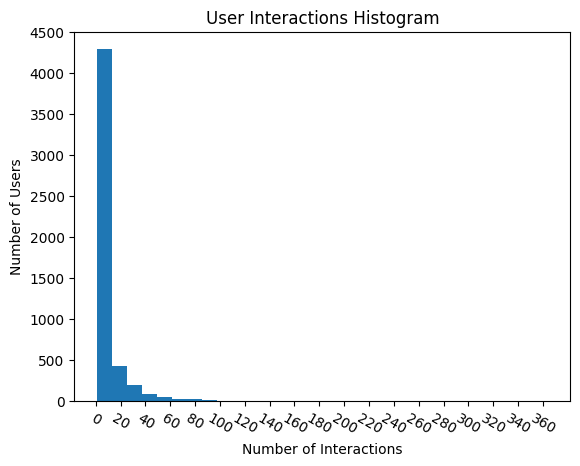

In [3]:
#Grouping the amount of articles by email
email_by_articles = df.groupby(['email']).count()['article_id'].sort_values(ascending=False)

# Plotting the histogram
plt.hist(email_by_articles, bins=30)
plt.ylim(0, 4500)
plt.xticks(np.arange(0, 364, step=20),rotation=-30)

# Adding labels and title
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.title('User Interactions Histogram')

# Displaying the histogram
plt.show()


In [4]:
# 50% of individuals interact with 3 or fewer.
median_val = email_by_articles.median()
print(f"The median number of user-article interactions is {median_val}.")
# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = email_by_articles.max()
print(f"The maximum number of user-article interactions a user is {max_views_by_user}.")

The median number of user-article interactions is 3.0.
The maximum number of user-article interactions a user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [5]:
# Find and explore duplicate articles
ind_duplicates = df_content['article_id'].duplicated()
print(f"There are {ind_duplicates.sum()} duplicate articles.")

There are 5 duplicate articles.


In [6]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [7]:
unique_emails = len(df['email'].unique())
article_ids = len(df_content['article_id'].unique())
print(f"There are a total of {unique_emails} unique emails and {article_ids} articles.")


There are a total of 5149 unique emails and 1051 articles.


In [8]:
# The number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()
print(f"There are a total of {unique_articles} unique articles with at least one interaction.")

# The number of unique articles on the IBM platform
total_articles = df_content['article_id'].nunique()
print(f"There are a total of {total_articles} unique articles on the IBM platform.")

# The number of unique users
unique_users = df['email'].nunique()
print(f"There are a total of {unique_users} unique users.")

# The number of user-article interactions
user_article_interactions = df['article_id'].count()
print(f"There are a total of {user_article_interactions} user-article interactions.")

There are a total of 714 unique articles with at least one interaction.
There are a total of 1051 unique articles on the IBM platform.
There are a total of 5148 unique users.
There are a total of 45993 user-article interactions.


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [9]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df.groupby(['article_id']).count()['email'].idxmax())
print(f"The most viewed article in the dataset is the article_id {most_viewed_article_id}.")

# The most viewed article in the dataset was viewed how many times?
max_views = df.groupby(['article_id']).count()['email'].max()
print(f"The most viewed article in the dataset was viewed {max_views} times.")

The most viewed article in the dataset is the article_id 1429.0.
The most viewed article in the dataset was viewed 937 times.


In [10]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

#convert article_id to string
df['article_id'] = df['article_id'].astype(str)
# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [11]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [12]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby('title')['article_id'].count().sort_values(ascending=False).head(n).index)
    
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article IDs 
    
    '''
    # Your code here
    top_articles = list(df.groupby('article_id')['article_id'].count().sort_values(ascending=False).head(n).index)
 
    return top_articles # Return the top article ids

In [13]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [14]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [15]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    # Create an empty matrix filled with zeros
    user_item = pd.pivot_table(df, index='user_id', columns='article_id', aggfunc=lambda x: 1, fill_value=0)
    
    #Drop an extra level of index that is not needed
    user_item.columns = user_item.columns.droplevel(level=0)

    #Convert columns to string
    user_item.columns = user_item.columns.astype(str)


    return user_item


user_item = create_user_item_matrix(df)

In [16]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [17]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Compute similarity scores between the input user and all other users then
    #storing the results in a dictionary
    main_user = user_item.loc[user_id]
    similar_users = {user: np.dot(main_user, user_item.loc[user]) for user in user_item.index if user != user_id}

    # Sort the dictionary by similarity values in descending order
    sorted_similar_users = sorted(similar_users.items(), key=lambda x: x[1], reverse=True)

    # Create a list of the user IDs
    most_similar_users = [user for user, _ in sorted_similar_users]

    return most_similar_users

def find_similar_users_with_score_(user_id, user_item=user_item):
    '''

    '''
    # Compute similarity scores between the input user and all other users then
    #storing the results in a dictionary
    main_user = user_item.loc[user_id]
    similar_users = {user: np.dot(main_user, user_item.loc[user]) for user in user_item.index if user != user_id}

    # Sort the dictionary by similarity values in descending order
    sorted_similar_users = sorted(similar_users.items(), key=lambda x: x[1], reverse=True)

    # Create a list of the user IDs and Score
    most_similar_users = [[user, score] for user, score in sorted_similar_users]

    return most_similar_users



In [18]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [19]:


def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = df[df['article_id'].isin(map(str, article_ids))]['title'].unique()
    return [name for name in article_names]





def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    # Get the user's row from the pivot table
    user_row = user_item.loc[user_id]

    # Extract the article ids where the user has interacted (values equal to 1)
    article_ids = user_row[user_row == 1].index.tolist()
 
    # Sort the article_ids list based on the number of interactions
    article_ids = sorted(article_ids, key=lambda x: user_item.loc[:, x].sum(), reverse=True)

    article_names = get_article_names(article_ids)
    

    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Get the articles seen by the user
    seen_articles, _ = get_user_articles(user_id)

    # Find the most similar users to the input user
    most_similar_users = find_similar_users(user_id)
    #container to store recommendations
    recs = []

    for user in most_similar_users:
        # Get the articles seen by the similar user
        article_ids, _ = get_user_articles(user)
        # adding the articles that the main user hasn't seen
        for article_id in article_ids:
            if article_id not in seen_articles and len(recs) < m:
                recs.append(article_id)
            if len(recs) == m:
                return recs



In [20]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['healthcare python streaming application demo',
 'ml optimization using cognitive assistant',
 'predicting churn with the spss random tree algorithm',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'model bike sharing data with spss',
 'analyze accident reports on amazon emr spark',
 'python machine learning: scikit-learn tutorial',
 'movie recommender system with spark machine learning',
 'learn basics about notebooks and apache spark']

In [21]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [22]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Find similar users to the current user and score their similarity
    neighbors_id_score = find_similar_users_with_score_(user_id)

    # Extract the similarity score and neighbor IDs into separate lists
    similarity = [item[1] for item in neighbors_id_score]
    neighbor_id = [item[0] for item in neighbors_id_score]

    # Count the number of interactions for each neighbor
    num_interactions = []
    for neighbor in neighbor_id:
        num_interactions.append(df[df['user_id'] == neighbor].shape[0])

    # Create a dataframe with the neighbor IDs, similarity scores, and number of interactions
    neighbors_df = pd.DataFrame({
        'neighbor_id': neighbor_id,
        'similarity': similarity,
        'num_interactions': num_interactions
    })

    # Sort the dataframe by similarity and number of interactions
    neighbors_df.sort_values('similarity', ascending=False, inplace=True)
    neighbors_df.sort_values('num_interactions', ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string



def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''

# Initialize empty lists for recommended article IDs and names
    recs = []
    rec_names = []

    # Get a dataframe of the top neighbors for the current user
    neighbors_df = get_top_sorted_users(user_id)

    # Get the IDs of articles the current user has already seen
    article_ids_seen = get_user_articles(user_id)[0]

    # For each neighbor, find articles they have seen that the current user has not seen
    # Add these articles to the recommended article IDs and names lists
    for neighbor in neighbors_df['neighbor_id']:
        neighbor_article_ids = get_user_articles(neighbor)[0]
        for article_id in neighbor_article_ids:
            if article_id not in article_ids_seen and len(recs) < m:
                recs.append(article_id)
                rec_names.append(get_article_names([article_id])[0])
            if len(recs) == m:
                return recs, rec_names
        if len(recs) == m:
            return recs, rec_names

    return recs, rec_names

    
    

In [23]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1429.0', '1364.0', '1314.0', '1431.0', '1427.0', '1160.0', '43.0', '1351.0', '1336.0']
The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use deep learning for image classification', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'analyze accident reports on amazon emr spark', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss', 'learn basics about notebooks and apache spark']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [24]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['neighbor_id'][0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'][9] # Find the 10th most similar user to user 131

In [25]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**
We could use the "get_top_articles" that sort the best articles based on how many interactions they had. A better way to make recommendations would be to obtain some info from the user. For instance, on many websites when you register, they ask simple questions about yourself, such as age and interests. 

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [26]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here



In [27]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

Challenge accepted! To perform this type of recommendation, I will perform a clustering technique on the texts provided in the 'doc_description' column. Since there is no "topic/genre" in the dataset, by performing a cluster analysis we can classify the texts. With that information we can recommend based on the type of article that the user has been reading.

In [28]:

#Removing NaN values from the DF content
df_content.dropna(subset=['doc_description'], how='any', inplace=True)

#Adding article_id as integer in the df
df['article_id_int'] = df['article_id'].astype(float).astype(int)


In [29]:

# List of texts
texts = df_content['doc_description'].tolist()

# Get the list of stopwords
stopwords_list = stopwords.words('english')

# Create TF-IDF vectorizer with stop words removal
vectorizer = TfidfVectorizer(stop_words=stopwords_list)

# Convert texts to TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(texts)

# Perform K-means clustering
k = 15  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tfidf_matrix)

# Get the cluster labels
cluster_labels = kmeans.labels_

#Adding cluster column to dataframe
text_cluster = []

# Print the cluster labels for each text
for i, text in enumerate(texts):
    text_cluster.append(cluster_labels[i])

#Adding the cluster column to dataframe
df_content['cluster'] = text_cluster

#Adding the number of article interactions column to dataframe
num_interactions = []
df_content['num_interactions'] = df_content['article_id'].apply(lambda x: df[df['article_id_int'] == x].shape[0])


c:\Users\danil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Now we can perform a similar approach as we did before. We will only recommend articles in the same cluster classification of the articles that the user viewed. 

In [30]:
def get_top_articles_by_cluster(clusters, df_content = df_content):
    '''
    INPUT:
    df_content - (pandas dataframe) df_content as defined at the top of the notebook
    user_clusters - (list) a list of clusters
    OUTPUT:
    top_articles_by_cluster - (dictionary) A dicionary with the top article ids
    as values and the cluster number as keys
     
    Description:
    Returns a dictionary where the keys are the cluster number and the values are the
    sorted top article ids in that cluster.
    '''
    top_articles_by_cluster = {}

    for i in clusters:
        cluster_articles = df_content[df_content['cluster'] == i]
        sorted_articles = sorted(cluster_articles.iterrows(), key=lambda x: x[1]['num_interactions'], reverse=True)
        top_articles = [article[1]['article_id'] for article in sorted_articles]
        top_articles_by_cluster[i] = top_articles

    return top_articles_by_cluster


def make_content_recs(user_id, m=10, df_content = df_content):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user based on content
    
    Description:
    Obtains the cluster labels for the user based on the article content and
    returns the articles of similar clusters that the user hasn't seen before and
    with the highest number of interactions.
    '''
    # Get the articles seen by the user
    seen_articles, article_ids = get_user_articles(user_id)


    # Obtain the cluster labels of the seen articles
    user_clusters =[]
    for id in seen_articles:
        try:
            row_index = df_content[df_content['article_id'] == int(float(id))].index[0]
            user_clusters.append(df_content.at[row_index, 'cluster'])
        except:
            pass

    
    
    # Storing only the unique clusters
    user_clusters = list(set(user_clusters))

    # Get the dictionary with articles from the same clusters
    top_articles_by_cluster = get_top_articles_by_cluster(user_clusters)
    # Container to store recommendations
    recs = []

    # Iterate over the clusters
    for cluster in top_articles_by_cluster.values():
        # Adding the articles that the user hasn't seen
        for article_id in cluster:
            if article_id not in seen_articles and len(recs) < m:
                recs.append(article_id)
            else:
                break
    
    article_names = df_content[df_content['article_id'].isin(map(int,recs))]['doc_full_name'].unique()

    return article_names




In [31]:
#Giving reommendations for user 110
content_recomendation_110= make_content_recs(110, 10)
print(content_recomendation_110)

['Uncover Product Insights Hidden in Stack Overflow'
 "Compose's first graph database: JanusGraph"
 'Seven Databases in Seven Days – Day 2: MongoDB'
 'Picking SQL or NoSQL? – A Compose View' 'RethinkDB Joinery'
 'How to use Db2 Warehouse on Cloud in Data Science Experience notebooks'
 'ibm-cds-labs/hybrid-cloud-tutorial'
 'DataLayer Exposed: Jonas Helfer & Joins Across Databases with GraphQL'
 'Why Relational Databases and R?'
 'Working with SQLite Databases using Python and Pandas']


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**The main idea of the approach I used to make the content-based recommendation is the classification of the texts based on how similar they are. I only provided a draft with a simple idea, but for this to be implemented it would take a few adjustments, such as: addressing situations when the person has few or too many clusters in their texts; determining what cluster should be prioritized (probably based on the number of interactions); and determining the number of clusters to use. Finally, the recommendation system does not select one item from each cluster. Those adjustments would be made based on the intentions of the company (Any clusters that should be prioritized? Or recommend articles equally?)**

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [32]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [33]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [34]:
# Perform SVD on the User-Item Matrix Here

# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix)


Differently than the lesson, this dataset does not contain NaNs and we are able to perform SVD on the user-item matrix.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

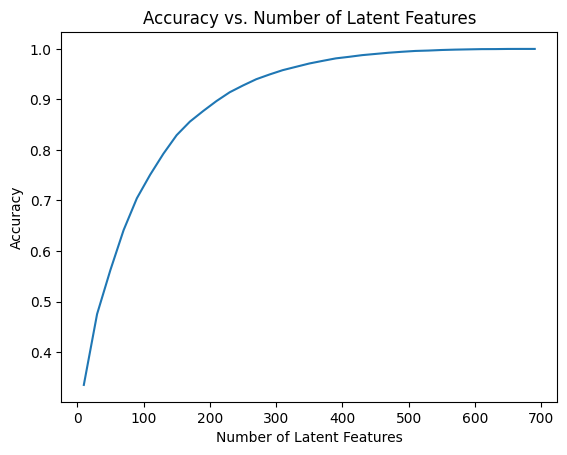

In [35]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [36]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index
    test_arts = user_item_test.columns.values
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [37]:
#How many users can we make predictions for in the test set?
print(len(set(user_item_train.index).intersection(user_item_test.index)))
#How many users in the test set are we not able to make predictions for because of the cold start problem? 
print(user_item_test.shape[0]-len(set(user_item_train.index).intersection(user_item_test.index)))
#How many articles can we make predictions for in the test set?
print(len(np.intersect1d(test_arts, user_item_train.columns.values)))
#How many articles in the test set are we not able to make predictions for because of the cold start problem?
print(len(df_test['article_id'].unique()) - len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique())))


20
662
574
0


In [38]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,# letter here, 
    'How many articles can we make predictions for in the test set?': b,# letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?':d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

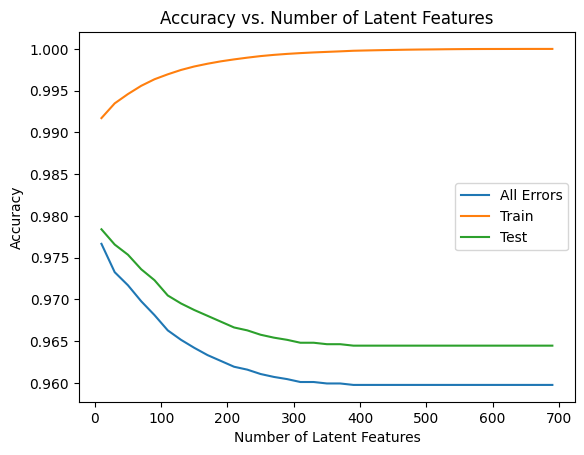

In [47]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

# Matching rows and columns to the test set

# Rows
test_idx = user_item_test.index

# Check which rows in the training set have labels present in the test set
row_idxs = user_item_train.index.isin(test_idx)

# Extract the subset of rows from u_train that correspond to the test set
u_test = u_train[row_idxs, :]

# Columns
test_col = user_item_test.columns

# Check which columns in the training set have labels present in the test set
col_idxs = user_item_train.columns.isin(test_col)

# Extract the subset of columns from vt_train that correspond to the test set
vt_test = vt_train[:, col_idxs]

# Test data
# Get the index (row labels) of the training set
train_idx = user_item_train.index

# Check which rows in the test set have labels present in the training set
row_idxs_2 = user_item_test.index.isin(train_idx)

# Extract a subset of the test data corresponding to the rows present in the training set
sub_user_item_test = user_item_test.loc[row_idxs_2]

# Generate a range of latent feature values
latent_feats = np.arange(10, 700+10, 20)


# Create containers to store the errors
all_errs = np.empty(latent_feats.shape)
train_errs = np.empty(latent_feats.shape)
test_errs = np.empty(latent_feats.shape)

for i, k in enumerate(latent_feats):
    # Restructure with k latent features for testing
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]

    # Calculate the predicted values by taking the dot product of the matrices
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))

    # This error represents the prediction error for the test data.
    all_errs[i] = 1 - ((np.sum(user_item_test_preds) + np.sum(np.sum(sub_user_item_test))) / (sub_user_item_test.shape[0] * sub_user_item_test.shape[1]))
    # Compute prediction accuracy
    train_errs[i] = accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten())
    test_errs[i] = accuracy_score(sub_user_item_test.values.flatten(), user_item_test_preds.flatten())


plt.figure()
plt.plot(latent_feats, all_errs, label='All Errors')
plt.plot(latent_feats, train_errs, label='Train')
plt.plot(latent_feats, test_errs, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**In general the accuracy was quite high, getting close to 1. But there are many limitations with the testing because we have only 20 users on the test data and most of the responses are 0. Thus, this generates a biased measurement.
In addition, we can see that the train group increased accuracy as the latent features increased. But this did not happen for the test group. This might be a combination of the small sample size with overfitting. It would be necessary to increase the sample size to effectively test the optimal number of latent features to avoid overfitting.
Finally, utilizing A/B testing might be a good strategy to effectively test the SVD effectiveness on recommendations.**

In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1

In [52]:
!jupyter nbconvert --to html Recommendations_with_IBM.ipynb

[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] Writing 893004 bytes to Recommendations_with_IBM.html
